## Trên tập dữ liệu 1000 mẫu

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
path = "/content/drive/MyDrive/KHDL/"

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
datasets = ["SmallDS", "datasets"]
folders = ["train", "val", "test"]
classes = ['male_face_image', 'female_face_image']


In [ ]:
def getDatasets(size):
  if size == "Small":
    path = "/content/drive/MyDrive/KHDL/"+datasets[0]
  elif size == "Big":
    path = "/content/drive/MyDrive/KHDL/"+datasets[1]
  dataset = {}
  for folder in folders:
    dataset[folder] = {"data": [], "label": []}
    folder_path = os.path.join(path, folder)
    for i in range(len(classes)):
      class_path = os.path.join(folder_path, classes[i])
      for filename in os.listdir( class_path ):
        file_path = os.path.join(class_path, filename)
        if os.path.isfile(file_path):
          dataset[folder]["data"].append(cv2.imread(file_path))
          dataset[folder]["label"].append(i)
  return dataset

In [ ]:
dataset = getDatasets("Small")

In [ ]:
print("Train size: ",len(dataset["train"]["data"]))
print("Validation size: ",len(dataset["val"]["data"]))
print("Test size: ",len(dataset["test"]["data"]))

Train size:  800
Validation size:  100
Test size:  100


## Tiền xử lý dữ liệu ảnh

### Thêm thuộc tính hướng nhìn

In [ ]:
import mediapipe as mp
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)
def HeadDirect(images):
    # To improve performance
    directs = []
    for image in images:
        image.flags.writeable = False

        # Get the result
        results = face_mesh.process(image)

        # To improve performance
        image.flags.writeable = True

        # Convert the color space from RGB to BGR
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        img_h, img_w, img_c = image.shape
        face_3d = []
        face_2d = []

        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                for idx, lm in enumerate(face_landmarks.landmark):
                    if idx == 33 or idx == 263 or idx == 1 or idx == 61 or idx == 291 or idx == 199:
                        if idx == 1:
                            nose_2d = (lm.x * img_w, lm.y * img_h)
                            nose_3d = (lm.x * img_w, lm.y * img_h, lm.z * 3000)

                        x, y = int(lm.x * img_w), int(lm.y * img_h)

                        # Get the 2D Coordinates
                        face_2d.append([x, y])

                        # Get the 3D Coordinates
                        face_3d.append([x, y, lm.z])       
                
                # Convert it to the NumPy array
                face_2d = np.array(face_2d, dtype=np.float64)

                # Convert it to the NumPy array
                face_3d = np.array(face_3d, dtype=np.float64)

                # The camera matrix
                focal_length = 1 * img_w

                cam_matrix = np.array([ [focal_length, 0, img_h / 2],
                                        [0, focal_length, img_w / 2],
                                        [0, 0, 1]])

                # The distortion parameters
                dist_matrix = np.zeros((4, 1), dtype=np.float64)

                # Solve PnP
                success, rot_vec, trans_vec = cv2.solvePnP(face_3d, face_2d, cam_matrix, dist_matrix)

                # Get rotational matrix
                rmat, jac = cv2.Rodrigues(rot_vec)

                # Get angles
                angles, mtxR, mtxQ, Qx, Qy, Qz = cv2.RQDecomp3x3(rmat)

                # Get the y rotation degree
                x = angles[0] * 360
                y = angles[1] * 360
                z = angles[2] * 360
            directs.append((x, y, z))
        else:
            directs.append((None, None, None))
    return np.array(directs)

In [ ]:
Headdirects = {}
for folder in folders:
  Headdirects[folder] = HeadDirect(dataset[folder]["data"])
  print(f"On {folder} data, directs shape: {Headdirects[folder].shape}")

On train data, directs shape: (800, 3)
On val data, directs shape: (100, 3)
On test data, directs shape: (100, 3)


#### Xử lý dữ liệu trống

In [ ]:
for folder in folders:
  df = pd.DataFrame(Headdirects[folder])
  df = df.fillna(df.median())
  Headdirects[folder] = df.values


[False]
[False]
[False]


### Đổi kích thước và hệ màu

In [ ]:
SIZE = (100,100)
for folder in folders:
  temp_data = dataset[folder]["data"]
  dataset[folder]["data"] = [cv2.resize(data, SIZE) for data in temp_data]
  print(f"{folder} shape after resize image: ",np.array(dataset[folder]["data"]).shape)

train shape after resize image:  (800, 100, 100, 3)
val shape after resize image:  (100, 100, 100, 3)
test shape after resize image:  (100, 100, 100, 3)


In [ ]:
SIZE = (100,100)
for folder in folders:
  temp_data = dataset[folder]["data"]
  dataset[folder]["data"] = [cv2.cvtColor(data, cv2.COLOR_BGR2GRAY) for data in temp_data]
  print(f"{folder} shape after change color mode: ",np.array(dataset[folder]["data"]).shape)

train shape after change color mode:  (800, 100, 100)
val shape after change color mode:  (100, 100, 100)
test shape after change color mode:  (100, 100, 100)


## EigenFace

In [ ]:
class EigenFace:
    def __init__(self) -> None:
        self.dataset = None
        self.K = 0
        self.Keigenvector = None
        self.image_shape = 0
    
    def fit(self,dataset, K = 100):
        self.image_shape = np.array(dataset).shape[1:3]
        self.dataset = np.array([np.array(data).reshape((self.image_shape[0] * self.image_shape[1], )) for data in dataset])
        self.K = K
        self._process()
    
    def _process(self):
        average = sum(np.array(self.dataset) / len(self.dataset))
        dataset_after_subtract = np.array([arr - average for arr in self.dataset])
        inv = np.linalg.pinv(dataset_after_subtract)
        C_quote = dataset_after_subtract.dot(dataset_after_subtract.T)

        w, v = np.linalg.eig(C_quote)
        Keigenvalue = w[0:self.K]
        Keigenvector = v[:, 0:self.K]
        Keigenvector = inv.dot(Keigenvector)
        Keigenvector = Keigenvector.astype(dtype='float64')
        self.Keigenvector = Keigenvector
    
    def get_Feature_Vector(self, images):
        if len(images.shape) != 3:
            raise Exception("Chiều đầu vào dữ liệu khác 3")
        
        images = images.reshape(-1, self.image_shape[0] * self.image_shape[1])
        inv2 = np.linalg.pinv(self.Keigenvector)
        W = inv2.dot(images.T)
        # data_result = self.Keigenvector.dot(W.reshape(-1,1))
        return W

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import copy
import warnings
import seaborn as sns
import pandas as pd
warnings.filterwarnings("ignore")

In [ ]:
maxpoint = [0,1,1]
for size in range(10,80,2):
  print(size)
  dataset2 = copy.deepcopy(dataset)
  for folder in folders:
    temp_data = dataset2[folder]["data"]
    dataset2[folder]["data"] = [cv2.resize(data, (size,size)) for data in temp_data]
  for folder in folders:
    temp_data = dataset2[folder]["data"]
    dataset2[folder]["data"] = [cv2.cvtColor(data, cv2.COLOR_BGR2GRAY) for data in temp_data]
  eigen = EigenFace()
  Ks = range(2,80,2)
  for K in Ks:
      eigen.fit(np.array(dataset2["train"]["data"]), K=K) 
      X_train_W = eigen.get_Feature_Vector(np.array(dataset2["train"]["data"])).T
      X_val_W = eigen.get_Feature_Vector(np.array(dataset2["val"]["data"])).T

      lgr = LogisticRegression(max_iter=3000)
      lgr.fit(X_train_W, dataset2["train"]["label"])
      point = accuracy_score(dataset2["val"]["label"],np.round(lgr.predict(X_val_W)))
      if maxpoint[0] < point:
        maxpoint[0] = point
        maxpoint[1] = K
        maxpoint[2] = size
print(f"The best hyperparameter:\nK: {maxpoint[1]}\nSize: {maxpoint[2]}\nAcurracy on validation: {maxpoint[0]}")

10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50
52
54
56
58
60
62
64
66
68
70
72
74
76
78
The best hyperparameter:
K: 36
Size: 38
Acurracy on validation: 0.89


In [ ]:
KBest = 36 #maxpoint[1]
Size = (38, 38) #(maxpoint[2], maxpoint[2])

In [ ]:
dataset2 = copy.deepcopy(dataset)
for folder in folders:
  temp_data = dataset2[folder]["data"]
  dataset2[folder]["data"] = [cv2.resize(data, Size) for data in temp_data]
for folder in folders:
  temp_data = dataset2[folder]["data"]
  dataset2[folder]["data"] = [cv2.cvtColor(data, cv2.COLOR_BGR2GRAY) for data in temp_data]

## Giảm chiều

#### Giảm chiều bằng cách lựa chọn đặc trưng

In [ ]:
eigen = EigenFace()
eigen.fit(np.array(dataset2["train"]["data"]), K=KBest)
X_train_W = eigen.get_Feature_Vector(np.array(dataset2["train"]["data"])).T
X_train_W = np.concatenate((X_train_W, Headdirects["train"]), axis=1)
F_p_values = mutual_info_classif(X_train_W, dataset2["train"]["label"])
print(F_p_values)

[0.06836981 0.02682178 0.16403007 0.02487506 0.00884588 0.
 0.0147466  0.00658522 0.02781324 0.03201903 0.01423024 0.
 0.         0.02532153 0.01197343 0.00050873 0.02486983 0.04926673
 0.01648628 0.00366626 0.         0.00288243 0.01575648 0.02411739
 0.         0.0032134  0.03434996 0.02843355 0.         0.
 0.01381557 0.01640501 0.00660206 0.03525348 0.         0.
 0.         0.         0.01292677]


Ba thông số cuối cùng thể hiện hướng nhìn không ảnh hưởng nhiều đến độ chính xác

In [ ]:
vitri = (-F_p_values).argsort()[:]
print("Số đặc trưng trích xuất từ vector ban đầu:", len(vitri))
print("Vị trí:", vitri)

Số đặc trưng trích xuất từ vector ban đầu: 39
Vị trí: [ 2  0 17 33 26  9 27  8  1 13  3 16 23 18 31 22  6 10 30 38 14  4 32  7
 19 25 21 15 36 35 34 20 37 28 11 12 24  5 29]


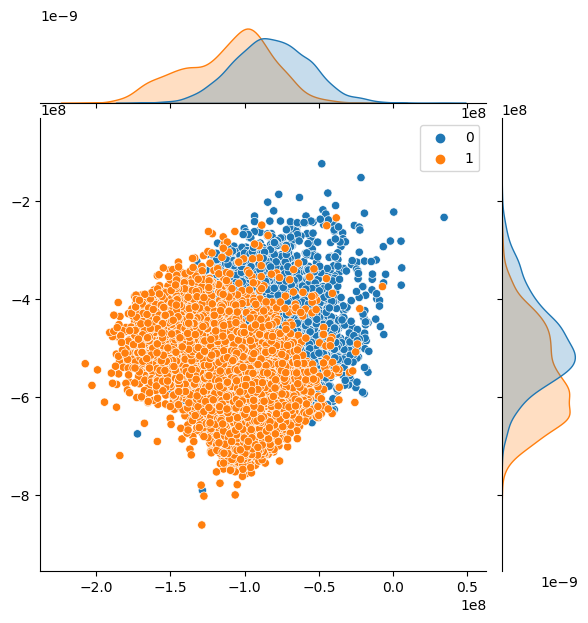

In [ ]:
X_train_W = eigen.get_Feature_Vector(np.array(dataset2["train"]["data"])).T
sns.jointplot(
    data=X_train_W,
    x=X_train_W[:, vitri[0]], y=X_train_W[:, vitri[1]], hue=dataset2["train"]["label"]
)

0 là nhãn của nam <br>
1 là nhãn của nữ

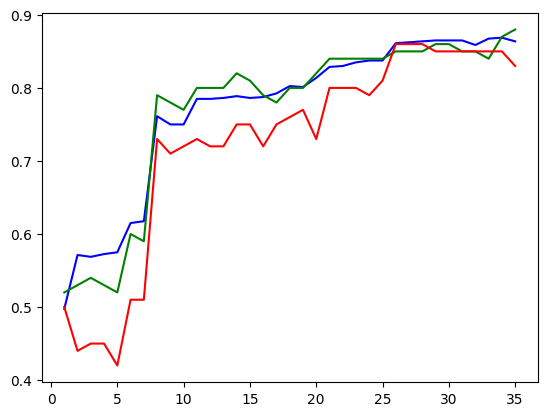

In [ ]:
train_his = []
val_his = []
test_his = []
for n in range(1,len(F_p_values)):
  vitri = (-F_p_values).argsort()[:n]
  eigen = EigenFace()
  eigen.fit(np.array(dataset2["train"]["data"]), K=KBest)
  X_train_W = eigen.get_Feature_Vector(np.array(dataset2["train"]["data"])).T
  X_train_W = X_train_W[:,vitri]
  X_val_W = eigen.get_Feature_Vector(np.array(dataset2["val"]["data"])).T
  X_val_W = X_val_W[:,vitri]
  X_test_W = eigen.get_Feature_Vector(np.array(dataset2["test"]["data"])).T
  X_test_W = X_test_W[:,vitri]
  lgr = LogisticRegression(max_iter=2000)
  lgr.fit(X_train_W, dataset2["train"]["label"])

  score_on_train = accuracy_score(dataset2["train"]["label"],np.round(lgr.predict(X_train_W)))
  score_on_val = accuracy_score(dataset2["val"]["label"],np.round(lgr.predict(X_val_W)))
  score_on_test = accuracy_score(dataset2["test"]["label"],np.round(lgr.predict(X_test_W)))
  train_his.append(score_on_train)
  val_his.append(score_on_val)
  test_his.append(score_on_test)
plt.plot(range(1,len(F_p_values)), train_his , 'b', label='Train')
plt.plot(range(1,len(F_p_values)), val_his , 'g', label='Validation')
plt.plot(range(1,len(F_p_values)), test_his , 'r', label='Test')

#### Kết quả khi sử dụng toàn bộ đặc trưng của dữ liệu để dự đoán

In [ ]:
eigen = EigenFace()
eigen.fit(np.array(dataset2["train"]["data"]), K=KBest)
X_train_W = eigen.get_Feature_Vector(np.array(dataset2["train"]["data"])).T
X_train_W = X_train_W
X_val_W = eigen.get_Feature_Vector(np.array(dataset2["val"]["data"])).T
X_val_W = X_val_W
X_test_W = eigen.get_Feature_Vector(np.array(dataset2["test"]["data"])).T
X_test_W = X_test_W
lgr = LogisticRegression(max_iter=2000)
lgr.fit(X_train_W, dataset2["train"]["label"])

score_on_train = accuracy_score(dataset2["train"]["label"],np.round(lgr.predict(X_train_W)))
score_on_val = accuracy_score(dataset2["val"]["label"],np.round(lgr.predict(X_val_W)))
score_on_test = accuracy_score(dataset2["test"]["label"],np.round(lgr.predict(X_test_W)))
print("Accuracy on train dataset:",score_on_train)
print("Accuracy on validation dataset:",score_on_val)
print("Accuracy on test dataset:",score_on_test)

Accuracy on train dataset: 0.87
Accuracy on validation dataset: 0.89
Accuracy on test dataset: 0.84


#### Thêm các đặt trưng hướng nhìn

In [ ]:
eigen = EigenFace()
eigen.fit(np.array(dataset2["train"]["data"]), K=KBest)
X_train_W = eigen.get_Feature_Vector(np.array(dataset2["train"]["data"])).T
X_train_W = np.concatenate((X_train_W, Headdirects["train"]), axis=1)
X_val_W = eigen.get_Feature_Vector(np.array(dataset2["val"]["data"])).T
X_val_W = np.concatenate((X_val_W, Headdirects["val"]), axis=1)
X_test_W = eigen.get_Feature_Vector(np.array(dataset2["test"]["data"])).T
X_test_W = np.concatenate((X_test_W, Headdirects["test"]), axis=1)

lgr = LogisticRegression(max_iter=2000)
lgr.fit(X_train_W, dataset2["train"]["label"])

score_on_train = accuracy_score(dataset2["train"]["label"],np.round(lgr.predict(X_train_W)))
score_on_val = accuracy_score(dataset2["val"]["label"],np.round(lgr.predict(X_val_W)))
score_on_test = accuracy_score(dataset2["test"]["label"],np.round(lgr.predict(X_test_W)))
print("Accuracy on train dataset:",score_on_train)
print("Accuracy on validation dataset:",score_on_val)
print("Accuracy on test dataset:",score_on_test)


Accuracy on train dataset: 0.87
Accuracy on validation dataset: 0.89
Accuracy on test dataset: 0.84


#### Thêm chuẩn hoá dữ liệu

In [ ]:
eigen = EigenFace()
eigen.fit(np.array(dataset2["train"]["data"]), K=KBest)
X_train_W = eigen.get_Feature_Vector(np.array(dataset2["train"]["data"])).T
X_train_W = X_train_W
X_val_W = eigen.get_Feature_Vector(np.array(dataset2["val"]["data"])).T
X_val_W = X_val_W
X_test_W = eigen.get_Feature_Vector(np.array(dataset2["test"]["data"])).T
X_test_W = X_test_W

scaler = StandardScaler()
scaler.fit(X_train_W)
X_train_W = scaler.transform(X_train_W)
X_val_W = scaler.transform(X_val_W)
X_test_W = scaler.transform(X_test_W)

lgr = LogisticRegression(max_iter=2000)
lgr.fit(X_train_W, dataset2["train"]["label"])

score_on_train = accuracy_score(dataset2["train"]["label"],np.round(lgr.predict(X_train_W)))
score_on_val = accuracy_score(dataset2["val"]["label"],np.round(lgr.predict(X_val_W)))
score_on_test = accuracy_score(dataset2["test"]["label"],np.round(lgr.predict(X_test_W)))
print("Accuracy on train dataset:",score_on_train)
print("Accuracy on validation dataset:",score_on_val)
print("Accuracy on test dataset:",score_on_test)

Accuracy on train dataset: 0.9025
Accuracy on validation dataset: 0.89
Accuracy on test dataset: 0.91


### Ma trận nhầm lẫn

In [ ]:
print("Confusion matrix on validation")
print(confusion_matrix(dataset2["val"]["label"],np.round(lgr.predict(X_val_W))))
print("Confusion matrix on test")
print(confusion_matrix(dataset2["test"]["label"],np.round(lgr.predict(X_test_W))))

Confusion matrix on validation
[[40  8]
 [ 3 49]]
Confusion matrix on test
[[39 11]
 [ 5 45]]


Validation: 
[5, 9, 11, 16, 18, 29, 32, 45, 69, 70, 76]
nam bị nhầm thành nữ:  8
nữ bị nhầm thành nam:  3


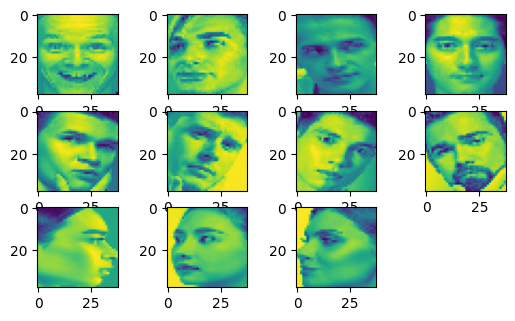

In [ ]:
print("Validation: ")
predicts = np.round(lgr.predict(X_val_W))
confusions_index = [i for i in range(len(predicts)) if predicts[i] != dataset2["val"]["label"][i]]
print(confusions_index)
confusions = np.array(dataset2["val"]["label"])[confusions_index]
counter = 0
w = h = int(np.sqrt(len(confusions_index)))+1
print("nam bị nhầm thành nữ: ", list(confusions).count(0))
print("nữ bị nhầm thành nam: ", list(confusions).count(1))
for i in confusions_index:
  counter += 1
  plt.subplot(w, h, counter)
  plt.imshow(dataset2["val"]["data"][i])

Test: 
[9, 17, 23, 26, 35, 41, 43, 44, 46, 48, 49, 61, 75, 76, 87, 93]
nam bị nhầm thành nữ:  11
nữ bị nhầm thành nam:  5


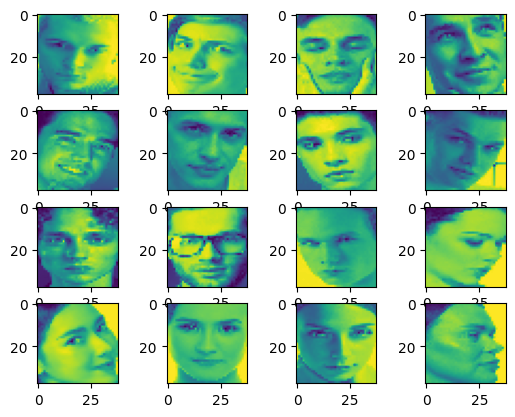

In [ ]:
print("Test: ")
predicts = np.round(lgr.predict(X_test_W))
confusions_index = [i for i in range(len(predicts)) if predicts[i] != dataset2["test"]["label"][i]]
print(confusions_index)
confusions = np.array(dataset2["test"]["label"])[confusions_index]
counter = 0
w = h = int(np.sqrt(len(confusions_index)))+1
print("nam bị nhầm thành nữ: ", list(confusions).count(0))
print("nữ bị nhầm thành nam: ", list(confusions).count(1))
for i in confusions_index:
  counter += 1
  plt.subplot(w, h, counter)
  plt.imshow(dataset2["test"]["data"][i])

## Trên tập dữ liệu 10000 mẫu

In [ ]:
dataset = getDatasets("Big")

In [ ]:
print("Train size: ",len(dataset["train"]["data"]))
print("Validation size: ",len(dataset["val"]["data"]))
print("Test size: ",len(dataset["test"]["data"]))

Train size:  8350
Validation size:  1045
Test size:  1047


In [ ]:
SIZE = (100,100)
for folder in folders:
  temp_data = dataset[folder]["data"]
  dataset[folder]["data"] = [cv2.resize(data, Size) for data in temp_data]
  print(f"{folder} shape after resize image: ",np.array(dataset[folder]["data"]).shape)
for folder in folders:
  temp_data = dataset[folder]["data"]
  dataset[folder]["data"] = [cv2.cvtColor(data, cv2.COLOR_BGR2GRAY) for data in temp_data]
  print(f"{folder} shape after change color mode: ",np.array(dataset[folder]["data"]).shape)

train shape after resize image:  (8350, 38, 38, 3)
val shape after resize image:  (1045, 38, 38, 3)
test shape after resize image:  (1047, 38, 38, 3)
train shape after change color mode:  (8350, 38, 38)
val shape after change color mode:  (1045, 38, 38)
test shape after change color mode:  (1047, 38, 38)


In [ ]:
eigen = EigenFace()
eigen.fit(np.array(dataset2["train"]["data"]), K=KBest)
X_train_W = eigen.get_Feature_Vector(np.array(dataset2["train"]["data"])).T


In [ ]:

scaler = StandardScaler()
scaler.fit(X_train_W)
X_train_W = scaler.transform(X_train_W)

F_p_values = mutual_info_classif(X_train_W, dataset2["train"]["label"])
print(F_p_values)

vitri = (-F_p_values).argsort()[:]
print("Số đặc trưng trích xuất từ vector ban đầu:", len(vitri))
print("Vị trí:", vitri)

[0.09718014 0.03274061 0.14020719 0.05683088 0.01889423 0.0203221
 0.00032959 0.00807711 0.05145734 0.00555001 0.         0.00438057
 0.0171524  0.02159448 0.02672154 0.00878611 0.01294271 0.00339616
 0.01430474 0.01462633 0.02160967 0.         0.01960094 0.0096254
 0.0147828  0.         0.00743234 0.01237956 0.01309654 0.00862948
 0.0194912  0.         0.00817724 0.00185941 0.         0.01220703]
Số đặc trưng trích xuất từ vector ban đầu: 36
Vị trí: [ 2  0  3  8  1 14 20 13  5 22 30  4 12 24 19 18 28 16 27 35 23 15 29 32
  7 26  9 11 17 33  6 21 10 25 31 34]


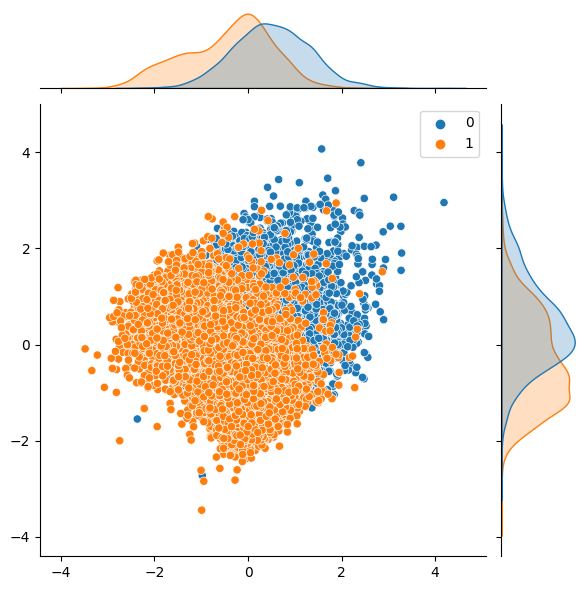

In [ ]:
sns.jointplot(
    data=X_train_W,
    x=X_train_W[:, vitri[0]], y=X_train_W[:, vitri[1]], hue=dataset2["train"]["label"]
)

0 là nhãn của nam <br>
1 là nhãn của nữ

In [ ]:
X_train_W = eigen.get_Feature_Vector(np.array(dataset2["train"]["data"])).T
X_train_W = X_train_W
X_val_W = eigen.get_Feature_Vector(np.array(dataset2["val"]["data"])).T
X_val_W = X_val_W
X_test_W = eigen.get_Feature_Vector(np.array(dataset2["test"]["data"])).T
X_test_W = X_test_W

lgr = LogisticRegression(max_iter=2000)
lgr.fit(X_train_W, dataset2["train"]["label"])

score_on_train = accuracy_score(dataset2["train"]["label"],np.round(lgr.predict(X_train_W)))
score_on_val = accuracy_score(dataset2["val"]["label"],np.round(lgr.predict(X_val_W)))
score_on_test = accuracy_score(dataset2["test"]["label"],np.round(lgr.predict(X_test_W)))
print("Accuracy on validation dataset:",score_on_train)
print("Accuracy on validation dataset:",score_on_val)
print("Accuracy on test dataset:",score_on_test)

Accuracy on validation dataset: 0.8516167664670659
Accuracy on validation dataset: 0.8210526315789474
Accuracy on test dataset: 0.8624641833810889


In [ ]:
X_train_W = eigen.get_Feature_Vector(np.array(dataset2["train"]["data"])).T
X_train_W = X_train_W
X_val_W = eigen.get_Feature_Vector(np.array(dataset2["val"]["data"])).T
X_val_W = X_val_W
X_test_W = eigen.get_Feature_Vector(np.array(dataset2["test"]["data"])).T
X_test_W = X_test_W

scaler = StandardScaler()
scaler.fit(X_train_W)
X_train_W = scaler.transform(X_train_W)
X_val_W = scaler.transform(X_val_W)
X_test_W = scaler.transform(X_test_W)

lgr = LogisticRegression(max_iter=2000)
lgr.fit(X_train_W, dataset2["train"]["label"])

score_on_train = accuracy_score(dataset2["train"]["label"],np.round(lgr.predict(X_train_W)))
score_on_val = accuracy_score(dataset2["val"]["label"],np.round(lgr.predict(X_val_W)))
score_on_test = accuracy_score(dataset2["test"]["label"],np.round(lgr.predict(X_test_W)))
print("Accuracy on validation dataset:",score_on_train)
print("Accuracy on validation dataset:",score_on_val)
print("Accuracy on test dataset:",score_on_test)


Accuracy on validation dataset: 0.8792814371257485
Accuracy on validation dataset: 0.8421052631578947
Accuracy on test dataset: 0.8796561604584527


Kết luận: <br>
Ở trên hai tập dữ liệu, thuật toán eigenface kết hợp với cách mô hình phân lớp đều cho ra kết quả tương đối tốt, độ chính xác trên các tập dữ liệu đều cao hơn 80%. <br>
Các kết quả nhận dạng nhầm nguyên nhân có thể là do một số đặc điểm trên gương mặt, do góc xoay và hướng nhìn của đầu và một số vật thể (như kính, tay,...) làm biến đổi các thông số của vector đặc trưng.